# Community detection

A community is a group of people who are homogeneous in some features. Marketers want to find communities so that they can target them. It is not trivial to identify communities from a given network.  

Community detection deals with identifying networks based only on the network topology. nodes in the community are closer than the nodes outside the community. What is closeness? To define closeness, we need to
1. Define distance metric based on network topology
2. Quantify nodes in a community are closer wth each other than nodes outside the community  

There are two approaches, bottom-up and top-down.  

## Girwan Newman Algorithm  
The most popular algorithm for network community detection is the Girvan-Newman algorithm. It is a top down approach where we take the whole network and try to break it into two communities. This can be continued till the bottom.   
Steps:  
1. Define betweenneess mesure for each edge   
2. Find the edge with maximum betweenness and remove it (The edge most in-between in the network connects up most number of pairs of nodes)  
3. Recalculate and repeat    

The example that we are using in this blog is the [Zachary Karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). It contains 34 members, and after an internal conflict, the club split into two. Our goal is to find if we can predict out how they split based on communities.

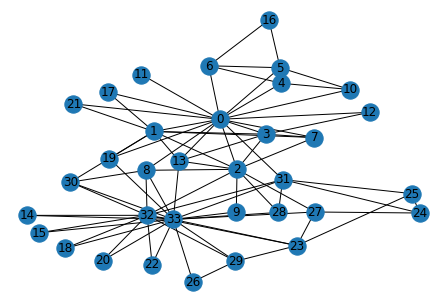

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
G = nx.karate_club_graph()
nx.draw_kamada_kawai(G, with_labels=True)

In [3]:
# Calculating the betweenness centrality
btw_centrality = nx.algorithms.centrality.edge_betweenness_centrality(G)

# Sorting based on the betweenness centraliy and displaying the first 10 edges.
sorted(btw_centrality.items(), key = lambda item:item[1], reverse = True)[0:10]

[((0, 31), 0.1272599949070537),
 ((0, 6), 0.07813428401663695),
 ((0, 5), 0.07813428401663694),
 ((0, 2), 0.0777876807288572),
 ((0, 8), 0.07423959482783014),
 ((2, 32), 0.06898678663384543),
 ((13, 33), 0.06782389723566191),
 ((19, 33), 0.05938233879410351),
 ((0, 11), 0.058823529411764705),
 ((26, 33), 0.0542908072319837)]

In [4]:
def girwan_newman(G, no_of_components_to_split):
    while(no_of_components_to_split > nx.algorithms.components.number_connected_components(G)):
        # Calculate the betweenness centrality
        btw_centrality = nx.algorithms.centrality.edge_betweenness_centrality(G)
        # sort based on betweenness centrality
        sorted_edges = sorted(btw_centrality.items(), key = lambda item:item[1], reverse = True)[0]
        print('Removing the edge', sorted_edges)
        # remove edge which has highest centrality
        G.remove_edge(*sorted_edges[0])

    # Check if graph is split
    if(no_of_components_to_split <= nx.algorithms.components.number_connected_components(G)):
        # Plot the graph with both the nodes having different colors
        nx.draw_spring(G, with_labels=True)
        # return list of nodes in each community
        list_of_nodes = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
        return list_of_nodes

Removing the edge ((0, 31), 0.1272599949070537)
Removing the edge ((0, 2), 0.11924273983097515)
Removing the edge ((0, 8), 0.13782067605597018)
Removing the edge ((13, 33), 0.14617273782105492)
Removing the edge ((19, 33), 0.21966651886437982)
Removing the edge ((2, 32), 0.1786195286195287)
Removing the edge ((1, 30), 0.25601957954899124)
Removing the edge ((1, 2), 0.1947415329768271)
Removing the edge ((2, 3), 0.19191919191919182)
Removing the edge ((2, 7), 0.25445632798573975)
Removing the edge ((2, 13), 0.5080213903743315)


[{2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
 {0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}]

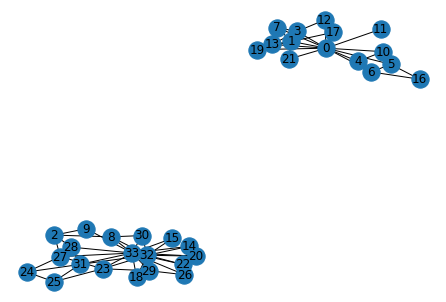

In [5]:
G = nx.karate_club_graph()
communities = girwan_newman(G, 2)
communities

We can see that after removing 11 edges based on the maximum betweenness values, the club splits into two parts. This can be seen below. These groups matches with what actually happened in the karate club. 

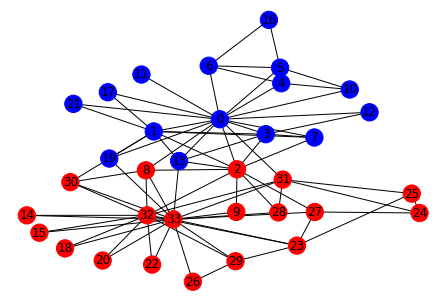

In [6]:
# Reinstanciste G if necessary
G = nx.karate_club_graph()

# Colors for edges
colors_for_edges = 'rbgoy'
pos = nx.spring_layout(G)
for i, nodes in enumerate(communities):
    for node in nodes:
        G.add_node(node,node_color = colors_for_edges[i])   
nx.draw_kamada_kawai(G, with_labels=True, node_color = list(nx.get_node_attributes(G,'node_color').values()))

NetworkX has a inbuilt function to calculate the same split.

In [7]:
karate_club_split = nx.algorithms.community.centrality.girvan_newman(G)
karate_club_split_tuple = tuple(sorted(c) for c in next(karate_club_split))
karate_club_split_tuple

([0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21],
 [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

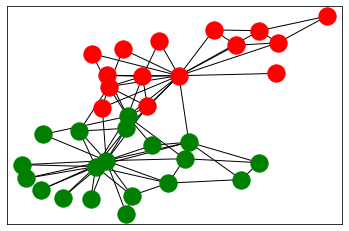

In [8]:
colors = 'rgb'
for i, nodes in enumerate(karate_club_split_tuple):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_color=colors[i])
    
nx.draw_networkx_edges(G,pos=pos)

## Ratio cut method
A more complex and advanced method is the ratio cut method. A cut in a graph is a set of edges, such that if we remove them, the network breaks up into two components. The procedure is as follows:  
1. Find the **minimum cut** among all the pair of nodes
2. Repeat over each of the two parts cut  

The minimum cut can be found using *Ratio Cut* parameter. Minimum cut wil have the least *ratio cut* among all the other cuts.  
$$ Ratio\,Cut\, (P_{Red}) = \frac{1}{number\_of\_partitions}\times (\frac{no\_of\_edges\_in\_partition1}{no\_of\_nodes\_in\_partition1} + \frac{no\_of\_edges\_in\_partition2}{no\_of\_nodes\_in\_partition2} + ..) $$  
This can be done quickly using an inbuilt function in NetworkX

In [9]:
from networkx.algorithms import community
communities = community.kernighan_lin_bisection(G, max_iter=100)

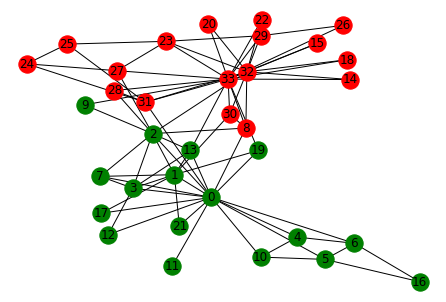

In [10]:
pos = nx.spring_layout(G)
nx.draw(G,pos, with_labels=True, node_size =100, node_color='w', node_shape = '.')

for i in range(len(communities)):
    nx.draw_networkx_nodes(G, pos, nodelist=communities[i], node_color=colors[i])

## Other methods
There are many other methods that can be used to identify communities, one of which is based on modularity. Modularity is defined as the "distance" from a random graph. essentially we will be comparing the number of edges with a community and the expected number of edges with a random graph. In NetworkX, we have a inbuilt function to implement this.

In [11]:
# How many ideal nodes: Louvain package
from community import community_louvain
# https://en.wikipedia.org/wiki/Louvain_method
community_louvain.best_partition(G)

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 3,
 5: 3,
 6: 3,
 7: 0,
 8: 1,
 9: 0,
 10: 3,
 11: 0,
 12: 0,
 13: 0,
 14: 1,
 15: 1,
 16: 3,
 17: 0,
 18: 1,
 19: 0,
 20: 1,
 21: 0,
 22: 1,
 23: 1,
 24: 2,
 25: 2,
 26: 1,
 27: 1,
 28: 2,
 29: 1,
 30: 1,
 31: 2,
 32: 1,
 33: 1}